# Identity Mining 

We will build identity mining tool for the corpus related to depression. 

## Dataset 

First we will start with the MyPersonality dataset with CES-D score. 

### Data cleaning

Let's clean the cesd_item_level.csv.   We will do 
* Arrange the answers according to the question numbers 
* Add the total score and verify with 939_userScores.csv 
* We will filter the data so that it contains only 939 data points, because other points contains invalid value.  

In the file “cesd_item_level.csv”, the scores are in the range [1,4], and questions 4, 8, 12 and 16 should be reverse-scored. This means that the CES-D scored should be computed as 

CES-D = (q1 - 1) + (q2 - 1) + (q3 - 1) + (4 - q4) + (q5 - 1) + …



In [2]:
import numpy as np
import pandas as pd

original = pd.read_csv('../project_materials/mypersonality_depression/cesd_item_level.csv', escapechar='\\')
cleanScore = pd.read_csv('../project_materials/mypersonality_depression/939_userScores.csv', escapechar='\\')

original_filtered = pd.DataFrame()


for i, row in cleanScore.iterrows():
    original_filtered = original_filtered.append( original[(original.userid == row.userid) & (original.time_completed == row.time_completed)]) 

original_filtered.shape


(939, 27)

In [3]:
original = original_filtered

original.question_order = original.question_order.apply(lambda x: np.fromstring(x, dtype=int, sep=","))

In [4]:
# %debug

for i in range(20):
    original['correctOrderQ' + str(i+1)] = 0

    
for i, row in original.iterrows():
    for index in range(row.question_order.shape[0]):
#         import ipdb; ipdb.set_trace()
        newOrder = 'correctOrderQ' + str(row.question_order[index])
        oldValue = 'q' + str(index + 1)
        original.loc[i,newOrder] = row[oldValue]
        



In [5]:
#Now we will get the CES-D score
original['score'] = 0
direction = [ 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, 1, 1, 1 ]
for index in range(1,21):
    dimName = 'correctOrderQ' + str(index)
    original.score = original.score + ( original[dimName] ) * direction[index-1]



### Data Exploration

Let's begin with the simple Histogram of scores.  

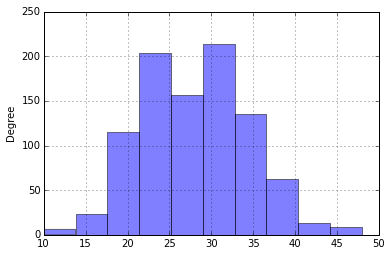

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
original.score.plot(kind='hist', alpha=0.5)

Now let's use gatherplot for interactive exploration.

https://gatherplot-dev.firebaseapp.com/#/ 



In [70]:
import dropbox
import re
import time
from firebase import firebase
from IPython.display import IFrame

def publish_gatherplot(p, dataname):
    
    filename = str(time.time())+'.csv'
    p.index.name = 'indexPandas'
    p.to_csv(filename)
    access_token = 'vwezSddRAD0AAAAAAAA0K2kAPqcpKnsShlfAPyIxSAYG0l2GxKfx5vtEkSyCeNOk'
    client = dropbox.client.DropboxClient(access_token)
    f = open(filename,'rb')
    response = client.put_file('./gatherplot/' + filename,f)
    print "uploaded:", response
    
    response = client.share('./gatherplot/' + filename, short_url=False)
    print 'Shared:', response
    url = response['url']
    match = re.search(r'https://www\.dropbox\.com/s/(.+)\?dl=0', url)
    if match:
#     print match.group(1)
        download_url = 'https://dl.dropboxusercontent.com/s/' + match.group(1)
        print download_url
        
    aFirebase = firebase.FirebaseApplication('https://gatherplot-dev.firebaseio.com',None)
    
    new_csv = {'name':dataname, 
           'uploader':"google:110953151430048855242", 
           'uploaderName': "Deok Gun Park",
           'url': download_url } 

    result = aFirebase.post('/csv',new_csv)
    print result
    

    return 'https://gatherplot-dev.firebaseapp.com/#/load/' + result['name']

In [71]:
# url = publish_gatherplot(original, "CES-D survey exploration - 939 filtered ")
url = u'https://gatherplot-dev.firebaseapp.com/#/load/-Jnisp3oVpf5W0h07lRP'

In [72]:
IFrame(url, 900,1200)

## Open IE 

We will analyze the result of Open IE. 

Open IE http://openie.allenai.org/
Open IE GitHub https://github.com/knowitall/openie

### Depressed Case 

We ran the reddit depressed.txt file and get the result.  


In [2]:
import pandas as pd
ieDepressed = pd.read_csv('../other_data/ie-depressed_trimmed.csv')


In [9]:
ieDepressed.head()
len(ieDepressed)

64213

The format is not so friendly to process.  Let's try human readable format.  
We ran the reddit depressed.txt and get the result as readable-ie-depressed.


In [30]:
import codecs
import re

f = codecs.open('../other_data/readable-ie-depressed.txt', 'rU', 'utf-8')

subject = []
relation = []
argument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        subject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        relation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        argument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
        


In [60]:
from nltk import *

lemmatizer = stem.WordNetLemmatizer()

lemaRelation = [ lemmatizer.lemmatize(word, pos='v') for phrase in relation for word in tokenize.word_tokenize(phrase)]

lemaRelationDist = FreqDist(lemaRelation)

relationDist = FreqDist(relation)
subjectDist = FreqDist(subject)
argumentDist = FreqDist(argument)

# relationDist.most_common(20)

for i,j in relationDist.most_common(20):
    print '* '  +  i




* was
* is
* 'm
* feel
* have
* 's
* know
* am
* to be
* want
* had
* do n't know
* think
* are
* get
* got
* said
* need
* do n't want
* started


#### Lemmatization

I tried running lemmatization on the relationship data.  However the data was actually hard to get meaningful insight with lemmatization because it loses the the context like **don't know**.  You can see that **don't know** in the orginal data is replaced with **do** and **n't** in the lemmatized version. 

##### Top 20 words with lemmatization
* be
* to
* do
* n't
* have
* 'm
* want
* just
* get
* feel
* know
* 've
* 's
* try
* not
* go
* think
* can
* ca
* make



##### Top 20 words without lemmatization 

* was
* is
* 'm
* feel
* have
* 's
* know
* am
* to be
* want
* had
* do n't know
* think
* are
* get
* got
* said
* need
* do n't want
* started

### Non Depressed Case 

Now I will do same for Non-depressed case.  First I will read the json file format. 

The raw data is too big in the sense it contains 800MB of text.   I will downsample it with 40MB of text which is 5% of total data.  

#### Segment original data into 400kb

In [16]:
import json
import codecs

numFiles = 100;

for num in range(numFiles):
    print num
    
    fDestination = codecs.open('../project_materials/reddit/segNDepression' + str(num) + '.txt',mode='w',encoding='utf-8')

    with codecs.open('../project_materials/reddit/reddit-all-data.out', encoding='utf-8') as fSource:
    #       nonDepressed = pd.DataFrame(json.loads(line) for line in f)
        for i,line in enumerate(fSource):

            if len(line) != 0 and i%2000 == num:
    #             print i
                a = json.loads(line)
                b = a[u'selftext']
                fDestination.write(b)
        
# fSource.close()
# fDestination.close()
            
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


#### Run the open ie on the segmented data

In [2]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call
import os

numFiles = 100

os.chdir('/Users/intuinno/codegit/openie/')

os.getcwd()

numProcess = 4;

pool = Pool(numProcess)

commands = [ "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_materials/reddit/segNDepression" + str(i)  + ".txt ../cl2_final/project_materials/reddit/ie-segNDepression" + str(i)  + ".txt '" for i in range(numFiles)] 

for i, returncode in enumerate(pool.imap(partial(call, shell=True), commands)):
    print i
    print returncode
    if returncode != 0:
       print("%d command failed: %d" % (i, returncode))

0
0
1
0
2
0
3
1
3 command failed: 1
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
0
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
0
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
0
74
0
75
0
76
0
77
0
78
0
79
0
80
0
81
0
82
0
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0


#### Now combine this data into a single file again

In [11]:
#### Now combine this data into a single file again.  
import codecs

os.chdir('/Users/intuinno/codegit/cl2_final/notebook')

fDestination  = codecs.open('../project_materials/reddit/ie-NDepression.txt', mode = 'w', encoding='utf-8')

for num in range(numFiles):
    print num
    
    fSource = codecs.open('../project_materials/reddit/ie-segNDepression' + str(num) + '.txt',mode='r',encoding='utf-8')

#     for i,line in enumerate(fSource):
    fDestination.write( fSource.read())
        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


### Now Let's run the extraction of tuple for the Non depressed case


In [19]:
import codecs
import re

f = codecs.open('../other_data/ie-NDepression.txt', 'rU', 'utf-8')

NDsubject = []
NDrelation = []
NDargument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        NDsubject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        NDrelation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        NDargument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
        


In [21]:
import pandas as pd

NDtuple = pd.DataFrame({'subject':NDsubject, 'relation':NDrelation, 'argument':NDargument   })
NDtuple.to_csv('../other_data/NDtuples.csv', encoding='utf-8')

### Comparing KL divergence key contributors.  



In [67]:
from nltk import *

NDRelDist = FreqDist(NDrelation)
NDSubDist = FreqDist(NDsubject)
NDArguDist = FreqDist(NDargument)

NDRelDist.most_common(50)

NDRelDist['is']
print relationDist.freq('isA2')

laplaceRel = LaplaceProbDist(relationDist)
laplaceNDRel = LaplaceProbDist(NDRelDist)

print laplaceRel.prob('isA2')

klContributionRelDepressedToNonDepressed = {} 
klContributionRelNonDepressedToDepressed = {}

for k in NDRelDist.keys():
    klContributionRelDepressedToNonDepressed[k] = laplaceRel.prob(k) * (laplaceRel.logprob(k) - laplaceNDRel.logprob(k))

for k in relationDist.keys():
    klContributionRelNonDepressedToDepressed[k] = laplaceNDRel.prob(k) * (laplaceNDRel.logprob(k) - laplaceRel.logprob(k))


    
    

0.0
1.24351816158e-05


In [52]:
klContributionRelDepressedToNonDepressed

import operator

sorted_klDepressedToNonDepressed = sorted(klContributionRelDepressedToNonDepressed.items(), key=operator.itemgetter(1), reverse=True)


sorted_klNonDepressedToDepressed = sorted(klContributionRelNonDepressedToDepressed.items(), key=operator.itemgetter(1), reverse=True)

### Now let's compare the words that is different from depressed and nondepressed people



In [53]:

print 'KL Divergence key contributor from depressed to nondepressed'
for i in range(30):
    print str(i) + '. ' + sorted_klDepressedToNonDepressed[i][0] 

KL Divergence key contributor from depressed to nondepressed
0. feel
1. 'm
2. do n't know
3. was
4. hate
5. am
6. do n't want
7. know
8. felt
9. just feel
10. to be
11. wish
12. feels
13. 've been
14. do n't know what to do to do
15. just want
16. do n't feel
17. to die
18. do
19. just need
20. told
21. 'm not
22. just wish
23. lost
24. try
25. started
26. wake up
27. to talk
28. had
29. do n't have


In [54]:
print 'KL Divergence key contributor from nondepressed to depressed'
for i in range(30):
    print str(i) + '. ' + sorted_klNonDepressedToDepressed[i][0] 

KL Divergence key contributor from nondepressed to depressed
0. is
1. are
2. has
3. 'm looking
4. was wondering
5. would like
6. would be
7. used
8. have
9. looks
10. 'd like
11. bought
12. will be
13. use
14. to play
15. to use
16. 're
17. looked
18. am looking
19. says
20. like
21. saw
22. included
23. run
24. play
25. looking
26. include
27. found
28. can get
29. plan


In [59]:
for i in range(30):
    print sorted_klDepressedToNonDepressed[i][0] + ' | ' + str(sorted_klDepressedToNonDepressed[i][1]) + ' | ' + sorted_klNonDepressedToDepressed[i][0] + ' | ' + str(sorted_klNonDepressedToDepressed[i][1] ) 

feel | 0.036620430121 | is | 0.0297772352733
'm | 0.0211951668249 | are | 0.017229603635
do n't know | 0.0108327928574 | has | 0.0064785837501
was | 0.00985627614106 | 'm looking | 0.00538325109695
hate | 0.00823105700206 | was wondering | 0.00448139125239
am | 0.00698328340166 | would like | 0.00370056753597
do n't want | 0.00556586136529 | would be | 0.00366413956505
know | 0.00473616217423 | used | 0.00349576098803
felt | 0.0041754733581 | have | 0.00285251716876
just feel | 0.00393774297973 | looks | 0.00281412171106
to be | 0.00393379740512 | 'd like | 0.00266112727532
wish | 0.0037668237477 | bought | 0.00257892519015
feels | 0.00350930165698 | will be | 0.0023917188746
've been | 0.00344553279076 | use | 0.00233604810325
do n't know what to do to do | 0.00328608437846 | to play | 0.00225175131167
just want | 0.00325192391721 | to use | 0.00216771632332
do n't feel | 0.00292347480345 | 're | 0.00216427755896
to die | 0.00258472861186 | looked | 0.0019868497743
do | 0.002344969970

So here is the comparison of top key differentiators.  

Depressed to NonDepressed | KLD score | NonDepressed to Depressed | KLD score
------------ | ------------- | ------------ | -------------
feel | 0.036620430121 | is | 0.0297772352733
'm | 0.0211951668249 | are | 0.017229603635
do n't know | 0.0108327928574 | has | 0.0064785837501
was | 0.00985627614106 | 'm looking | 0.00538325109695
hate | 0.00823105700206 | was wondering | 0.00448139125239
am | 0.00698328340166 | would like | 0.00370056753597
do n't want | 0.00556586136529 | would be | 0.00366413956505
know | 0.00473616217423 | used | 0.00349576098803
felt | 0.0041754733581 | have | 0.00285251716876
just feel | 0.00393774297973 | looks | 0.00281412171106
to be | 0.00393379740512 | 'd like | 0.00266112727532
wish | 0.0037668237477 | bought | 0.00257892519015
feels | 0.00350930165698 | will be | 0.0023917188746
've been | 0.00344553279076 | use | 0.00233604810325
do n't know what to do to do | 0.00328608437846 | to play | 0.00225175131167
just want | 0.00325192391721 | to use | 0.00216771632332
do n't feel | 0.00292347480345 | 're | 0.00216427755896
to die | 0.00258472861186 | looked | 0.0019868497743
do | 0.00234496997024 | am looking | 0.00186020227527
just need | 0.00232457533705 | says | 0.00162288714766
told | 0.00220530714892 | like | 0.00156547427076
'm not | 0.00220190139767 | saw | 0.00153061678674
just wish | 0.00219190453379 | included | 0.00151216917483
lost | 0.00209698332496 | run | 0.00148758905607
try | 0.00202329517571 | play | 0.00148171079383
started | 0.00197291885473 | looking | 0.00145494111641
wake up | 0.00184614958337 | include | 0.00144461132393
to talk | 0.00176865571138 | found | 0.00140188467898
had | 0.00173806268442 | can get | 0.0013639326444
do n't have | 0.00170597871196 | plan | 0.00127646126076


## The difference 'I' and 'me' usage pattern among the depressed people and nondepressed people.  



In [64]:
print subjectDist.freq('i')
print NDSubDist.freq('i')

0.549964961458
0.34516400597


In [68]:
print argumentDist.freq('me')
print NDArguDist.freq('me')

0.0298372654364
0.0148098605007


# LIWC Analysis

Now we will do LIWC analysis.  

## Build dictionary

I will build the category distribution of LIWC category.  To do that I will begin with liwc.dic file.  

From the liwc.dic file, I will extract the category and the words definition.  

* **liwc_def** : definition of category
* **liwc_words** : the words , and liwc category list tuple. 
* **getLIWC_Str** : get the string version of the liwc definition for words.  (ex: getLIWC_Str('abandons') returns ['affect', 'negemo', 'sad', 'cogmech', 'inhib'] 
* **getLIWC_Id** : get the numeric id version of the liwc definition for words. (ex: getLIWC_Id('affect') returns ['131', '133']

In [27]:

import pandas as pd
import re
import fnmatch


liwc_def = {}

for line in open('../other_data/liwc_defs.txt'):
    lineSplit = line.split()
    liwc_def[lineSplit[0]] = lineSplit[1]


liwc_words = []

for line in open('../other_data/liwc_words.txt'):
    lineSplit = line.split()
    liwc_words.append( (lineSplit[0],  lineSplit[1:len(lineSplit)] ) )

liwc_wordsExact = {}
liwc_wordsWild = {}

for line in open('../other_data/liwc_words.txt'):
    lineSplit = line.split()

    if lineSplit[0].endswith('*'):
        liwc_wordsWild[  lineSplit[0].rstrip('*') ] =   lineSplit[1:len(lineSplit)]
    else:
        liwc_wordsExact[lineSplit[0]] = lineSplit[1:len(lineSplit)]


def getLIWC_Id(w):
    for (reExp, catList) in liwc_words:
        if fnmatch.fnmatch(w, reExp):
            # print w + ' : ' + str(catList)
            return catList

def getLIWC_Str(w):
    for (reExp, catList) in liwc_words:
        if fnmatch.fnmatch(w, reExp):
            # print w + ' : ' + str(catList)
            return [liwc_def[catId] for  catId in catList ]

def getLIWC_IdFast(w):
        if w in liwc_wordsExact:
            # print w + ' : ' + str(catList)
            return liwc_wordsExact[w]
        else:
            for key, value in liwc_wordsWild.iteritems():
                if w.startswith(key):
                    return value



print getLIWC_Str('abandons')
print getLIWC_Id('affect')

print getLIWC_IdFast('abandons')
print getLIWC_IdFast('affect')



['affect', 'negemo', 'sad', 'cogmech', 'inhib']
['131', '133']
['125', '127', '130', '131', '137']
['131', '133']


### Let's run the code for the depressed case.  

In [24]:
import codecs
import re
from nltk import *

f = codecs.open('../project_materials/reddit/depressed.txt', 'rU', 'utf-8')

depressedAllText = word_tokenize(f.read())


liwcDist = FreqDist()



        

In [3]:
for (i,w) in enumerate(depressedAllText):
    wlower = w.lower()
    if i%10000 == 0:
        print i
    catList =  getLIWC_IdFast(wlower)
    if catList:
        for cat in catList:
            liwcDist[cat] += 1


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000
210000
220000
230000
240000
250000
260000
270000
280000
290000
300000
310000
320000
330000
340000
350000
360000
370000
380000
390000
400000
410000
420000
430000
440000
450000
460000
470000
480000
490000


In [4]:
liwcDist

FreqDist({'1': 263066, '2': 86637, '131': 84862, '11': 65150, '3': 60780, '250': 57242, '17': 53602, '4': 47228, '14': 38707, '12': 35839, ...})

## Now we will build a 80MB version of undepressed posts. 



In [5]:
import json
import codecs

numFiles = 1;

for num in range(numFiles):
    print num
    
    fDestination = codecs.open('../project_materials/reddit/nondepressed80MB' + str(num) + '.txt',mode='w',encoding='utf-8')

    with codecs.open('../project_materials/reddit/reddit-all-data.out', encoding='utf-8') as fSource:
    #       nonDepressed = pd.DataFrame(json.loads(line) for line in f)
        for i,line in enumerate(fSource):

            if len(line) != 0 and i%10 == num:
    #             print i
                a = json.loads(line)
                b = a[u'selftext']
                fDestination.write(b)

0


In [6]:
import multiprocessing as mp

def liwcMPparse(num):
    print num

    f = codecs.open('../project_materials/reddit/segNDepression' + str(num) + '.txt',mode='r',encoding='utf-8')

    depressedAllText = word_tokenize(f.read())


    liwcDist = FreqDist()

    for (i,w) in enumerate(depressedAllText):
        wlower = w.lower()
        catList =  getLIWC_IdFast(wlower)
        if catList:
            for cat in catList:
                liwcDist[cat] += 1

    return liwcDist


# pool = mp.Pool(processes=6)

# result = pool.map(liwcMPparse, range(100))

# liwcNDDist = reduce(lambda x, y: x+y, result)


In [7]:
import pickle

output = open('liwcNDDist.pkl', 'rb')

# Pickle dictionary using protocol 0.
liwcNDDist = pickle.load(output)

output.close()

In [18]:
FreqDist(liwcNDDist).N()


17278365

In [20]:
depressedProbDist = LaplaceProbDist( liwcDist )
nondepressedProbDist = LaplaceProbDist(FreqDist(liwcNDDist))

numTokenDepressed = float(liwcDist.N())
numTokenNonDepressed = float(FreqDist(liwcNDDist).N())

klLIWC_D_ND = {} 
klLIWC_ND_D = {}

for k in liwcDist.keys():
    klLIWC_D_ND[k] = depressedProbDist.prob(k) * (depressedProbDist.logprob(k) - nondepressedProbDist.logprob(k))

for k in liwcNDDist.keys():
    klLIWC_ND_D[k] = nondepressedProbDist.prob(k) * (nondepressedProbDist.logprob(k) - depressedProbDist.logprob(k))

import operator

sorted_klLIWC_D_ND = sorted(klLIWC_D_ND.items(), key=operator.itemgetter(1), reverse=True)


sorted_klLIWC_ND_D = sorted(klLIWC_ND_D.items(), key=operator.itemgetter(1), reverse=True)
    
for i in range(30):
    print liwc_def[sorted_klLIWC_D_ND[i][0]] + ' | ' + str(sorted_klLIWC_D_ND[i][1]) + ' | ' + str(liwcDist[sorted_klLIWC_D_ND[i][0]]/numTokenDepressed) + ' | ' + liwc_def[sorted_klLIWC_ND_D[i][0]] + ' | ' + str(sorted_klLIWC_ND_D[i][1] ) + ' | ' + str(liwcDist[ sorted_klLIWC_ND_D[i][0]]/numTokenNonDepressed) 
    

i | 0.0297223407593 | 0.0366498037837 | article | 0.0188451679091 | 0.00113390358405
ppron | 0.0200478226323 | 0.0471664070885 | funct | 0.0121146129348 | 0.0152251674276
pronoun | 0.0190746365626 | 0.0672319185739 | preps | 0.0118820307886 | 0.00310226112251
negemo | 0.0115120514733 | 0.012703423561 | space | 0.00972325748048 | 0.00128750608058
sad | 0.00819327062349 | 0.00455290079612 | relativ | 0.00943656745716 | 0.00331292920366
affect | 0.00677807591567 | 0.0249319237733 | money | 0.00603035430839 | 9.76944288421e-05
health | 0.00474421769244 | 0.00398563124064 | leisure | 0.00583158380293 | 0.000197993270775
bio | 0.00363245390444 | 0.00804886433566 | social | 0.00489509464607 | 0.00203074770095
past | 0.00344426103127 | 0.0141150012921 | tentat | 0.00442704103531 | 0.000808351947652
adverb | 0.0030219613743 | 0.0207259032662 | you | 0.00435462688474 | 0.000170270740316
feel | 0.00290326564529 | 0.00380326688287 | see | 0.00415504982348 | 0.000118413981878
verb | 0.0026274908697

So here is the comparison of top key differentiators.  

Depressed to NonDepressed | KLD score | Absolute Frequency | NonDepressed to Depressed | KLD score | Absolute Frequency
----------------|---------|-------------|----------------
i | 0.0297223407593 | 0.0366498037837 | article | 0.0188451679091 | 0.00113390358405
ppron | 0.0200478226323 | 0.0471664070885 | funct | 0.0121146129348 | 0.0152251674276
pronoun | 0.0190746365626 | 0.0672319185739 | preps | 0.0118820307886 | 0.00310226112251
negemo | 0.0115120514733 | 0.012703423561 | space | 0.00972325748048 | 0.00128750608058
sad | 0.00819327062349 | 0.00455290079612 | relativ | 0.00943656745716 | 0.00331292920366
affect | 0.00677807591567 | 0.0249319237733 | money | 0.00603035430839 | 9.76944288421e-05
health | 0.00474421769244 | 0.00398563124064 | leisure | 0.00583158380293 | 0.000197993270775
bio | 0.00363245390444 | 0.00804886433566 | social | 0.00489509464607 | 0.00203074770095
past | 0.00344426103127 | 0.0141150012921 | tentat | 0.00442704103531 | 0.000808351947652
adverb | 0.0030219613743 | 0.0207259032662 | you | 0.00435462688474 | 0.000170270740316
feel | 0.00290326564529 | 0.00380326688287 | see | 0.00415504982348 | 0.000118413981878
verb | 0.00262749086973 | 0.0505576081246 | quant | 0.00373701288603 | 0.000759504733231
anx | 0.00247461716498 | 0.00218371618208 | achieve | 0.00343759263368 | 0.000415085570886
insight | 0.0024269920569 | 0.0106849993287 | incl | 0.00316966835962 | 0.00122841484133
family | 0.0021878415283 | 0.00187098070896 | work | 0.0030210406991 | 0.000426834367719
time | 0.00206420288525 | 0.0203534143652 | posemo | 0.00262936828665 | 0.000894413331354
present | 0.001796323292 | 0.0300373497725 | future | 0.00253504445006 | 0.000171775512324
negate | 0.00145195699011 | 0.00462662255777 | auxverb | 0.0025211185846 | 0.00207421246165
friend | 0.00144378097066 | 0.00153962079078 | we | 0.00245000031214 | 9.1906844195e-05
certain | 0.00132255539141 | 0.00567657564745 | cogmech | 0.00217265965231 | 0.00491146008317
anger | 0.00113611303231 | 0.00326005390225 | motion | 0.00198018212719 | 0.000425503223251
swear | 0.000941253493055 | 0.00118963642755 | conj | 0.00166383895428 | 0.0018528373489
death | 0.00078745052477 | 0.00110272235065 | number | 0.00158569006813 | 0.000155686027005
filler | 0.000763096871914 | 0.0019765192309 | percept | 0.00141067668628 | 0.000548547272847
excl | 0.000572189786165 | 0.0126110773543 | discrep | 0.00133501658561 | 0.000505603394766
sexual | 0.000453606382195 | 0.00131457541309 | inhib | 0.000834263117877 | 0.000114767803551
shehe | 0.00023569904543 | 0.00487572451031 | relig | 0.000743072070393 | 2.69122686087e-05
home | 0.000138698325475 | 0.00152953254971 | they | 0.000728530190696 | 0.000158521943482
humans | 6.94670700563e-05 | 0.00249257156249 | cause | 0.000579561156327 | 0.000465263929776
ipron | -4.71619196513e-05 | 0.0200655114855 | ingest | 0.000464977399827 | 7.35023250174e-05

##Application to facebook data

In this section I will try to apply the openIE and LIWC to facebook dataset.  I will use the dataset cleaned by Rashmi. 

The dataset files are following. 
* ../other_data/Depression_statuswise_tokens/ 
* ../other_data/neuroticism_tokenized/ 
* ../mypersonality_depression/939_userScores.csv
* ../mypersonality_neuroticism/userDictionary.csv 


### From the Neuroticism dataset make high score group and low score group

I will parse userDictionary.csv file to find people with high neurotism score and low score.  

In [2]:
import pandas as pd
import os

os.getcwd()
os.chdir('/Users/intuinno/codegit/cl2_final/notebook')

neuroticism = pd.read_csv('../project_materials/mypersonality_neuroticism/userDictionary.csv', escapechar='\\')



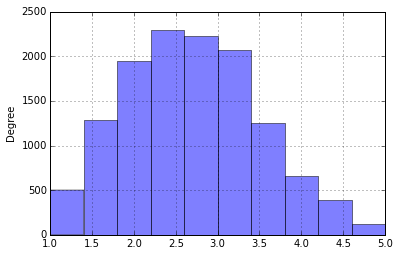

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
neuroticism.neu.plot(kind='hist', alpha=0.5)

In [4]:
# top_neu = neuroticism[neuroticism.neu >= neuroticism.neu.quantile(2.0/3)]
# bottom_neu = neuroticism[neuroticism.neu <= neuroticism.neu.quantile(1.0/3)]

top_neu = neuroticism[  neuroticism.neu <= 5.0  ].dropna()
top_neu = top_neu[top_neu.neu >=3.05].dropna()

bottom_neu = neuroticism[  neuroticism.neu <= 2.25  ].dropna()
# bottom_neu = top_neu[top_neu.neu >=3.05].dropna()



### Let's create an aggregated dataset for neuroticism

I will iterate over top_neu and bottom_neu to create a text file.  

In [29]:
import multiprocessing as mp
import codecs
from nltk import *

def liwcMPparseFileName(filename):
    
#     print filename

    f = codecs.open(filename,mode='r',encoding='cp1252')

    depressedAllText = word_tokenize(f.read())

    liwcDist = FreqDist()

    for (i,w) in enumerate(depressedAllText):
        wlower = w.lower()
        catList =  getLIWC_IdFast(wlower)
        if catList:
            for cat in catList:
                liwcDist[cat] += 1

    return liwcDist
    

In [30]:
# pool = mp.Pool(processes=6)

# a = '../other_data/neuroticism_tokenized/' + top_neu['userid'] + '_d_tokens.txt'
# b = a.values.tolist()

# result = pool.map(liwcMPparseFileName, b)



In [32]:
# liwcTopNeu = reduce(lambda x, y: x+y, result)

# import pickle

# output = open('liwcTopNeu.pkl', 'wb')

# # Pickle dictionary using protocol 0.
# pickle.dump(liwcTopNeu, output)

# output.close()


In [33]:
# pool = mp.Pool(processes=7)

# a = '../other_data/neuroticism_tokenized/' + bottom_neu['userid'] + '_d_tokens.txt'
# b = a.values.tolist()

# result = pool.map(liwcMPparseFileName, b)


In [34]:
# liwcBottomNeu = reduce(lambda x, y: x+y, result)

# import pickle

# output = open('liwcBottomNeu.pkl', 'wb')

# # Pickle dictionary using protocol 0.
# pickle.dump(liwcBottomNeu, output)

# output.close()


In [ ]:
import pickle 

output = open('liwcTopNeu.pkl', 'rb')

# Pickle dictionary using protocol 0.
liwcTopNeu = pickle.load(output)

output.close()

output = open('liwcBottomNeu.pkl','rb')
liwcBottomNeu = pickle.load(output)
output.close()
              

In [39]:
depressedProbDist = LaplaceProbDist( FreqDist(liwcTopNeu) )
nondepressedProbDist = LaplaceProbDist(FreqDist(liwcBottomNeu))

numTokenDepressed = float(FreqDist(liwcTopNeu).N())
numTokenNonDepressed = float(FreqDist(liwcBottomNeu).N())

klLIWC_D_ND = {} 
klLIWC_ND_D = {}

for k in liwcTopNeu.keys():
    klLIWC_D_ND[k] = depressedProbDist.prob(k) * (depressedProbDist.logprob(k) - nondepressedProbDist.logprob(k))

for k in liwcBottomNeu.keys():
    klLIWC_ND_D[k] = nondepressedProbDist.prob(k) * (nondepressedProbDist.logprob(k) - depressedProbDist.logprob(k))

import operator

sorted_klLIWC_D_ND = sorted(klLIWC_D_ND.items(), key=operator.itemgetter(1), reverse=True)


sorted_klLIWC_ND_D = sorted(klLIWC_ND_D.items(), key=operator.itemgetter(1), reverse=True)
    
for i in range(30):
    print liwc_def[sorted_klLIWC_D_ND[i][0]] + ' | ' + str(sorted_klLIWC_D_ND[i][1]) + ' | ' + str(liwcTopNeu[sorted_klLIWC_D_ND[i][0]]/numTokenDepressed) + ' | ' + liwc_def[sorted_klLIWC_ND_D[i][0]] + ' | ' + str(sorted_klLIWC_ND_D[i][1] ) + ' | ' + str(liwcBottomNeu[ sorted_klLIWC_ND_D[i][0]]/numTokenNonDepressed) 
    

i | 0.00282938886271 | 0.0246980717456 | relativ | 0.00318457349249 | 0.0576026429684
ppron | 0.00267635317635 | 0.0389303160858 | article | 0.00212949412778 | 0.021423463516
pronoun | 0.00240181235494 | 0.05667851791 | preps | 0.00208026807335 | 0.0440240140365
negemo | 0.00221129733922 | 0.0101825265614 | posemo | 0.00165977313043 | 0.0213131631055
adverb | 0.000989311382508 | 0.0193487814689 | space | 0.001553279819 | 0.0212382204428
anger | 0.00094784585952 | 0.0040414197755 | time | 0.00120480093307 | 0.0267618027708
bio | 0.000818482667599 | 0.0113922527212 | funct | 0.00116601346538 | 0.194440028209
cogmech | 0.000566872006315 | 0.0557357887709 | leisure | 0.00103932579177 | 0.00717242837943
conj | 0.000544400283461 | 0.0204642201056 | achieve | 0.000753812166191 | 0.00611219747721
sad | 0.000528000970531 | 0.00214810176893 | relig | 0.000635681305539 | 0.00198186086644
swear | 0.00049699297458 | 0.00196279917479 | social | 0.000542250074953 | 0.0319454921809
affect | 0.00049583

So here is the comparison of top key differentiators according to Neurocism score.   

High score to Low score | KLD score | Absolute Frequency | Low score to High score | KLD score | Absolute Frequency
----------------|---------|-------------|----------------
i | 0.00282938886271 | 0.0246980717456 | relativ | 0.00318457349249 | 0.0576026429684
ppron | 0.00267635317635 | 0.0389303160858 | article | 0.00212949412778 | 0.021423463516
pronoun | 0.00240181235494 | 0.05667851791 | preps | 0.00208026807335 | 0.0440240140365
negemo | 0.00221129733922 | 0.0101825265614 | posemo | 0.00165977313043 | 0.0213131631055
adverb | 0.000989311382508 | 0.0193487814689 | space | 0.001553279819 | 0.0212382204428
anger | 0.00094784585952 | 0.0040414197755 | time | 0.00120480093307 | 0.0267618027708
bio | 0.000818482667599 | 0.0113922527212 | funct | 0.00116601346538 | 0.194440028209
cogmech | 0.000566872006315 | 0.0557357887709 | leisure | 0.00103932579177 | 0.00717242837943
conj | 0.000544400283461 | 0.0204642201056 | achieve | 0.000753812166191 | 0.00611219747721
sad | 0.000528000970531 | 0.00214810176893 | relig | 0.000635681305539 | 0.00198186086644
swear | 0.00049699297458 | 0.00196279917479 | social | 0.000542250074953 | 0.0319454921809
affect | 0.000495838189021 | 0.0306040879178 | incl | 0.00045717974522 | 0.0153029549978
body | 0.00046594943636 | 0.00401795746344 | motion | 0.000408298617497 | 0.00836090724183
present | 0.000432850896434 | 0.0349326361374 | we | 0.000388803163398 | 0.00221052196418
discrep | 0.000411244412902 | 0.00659957146657 | auxverb | 0.000375734789407 | 0.0286611980495
shehe | 0.000377549795731 | 0.00305647016206 | work | 0.000362606519534 | 0.00658639251886
excl | 0.000368142113106 | 0.00994027745893 | quant | 0.000320693581752 | 0.00921232323902
health | 0.000350993924714 | 0.00313313903734 | ipron | 0.000247900469249 | 0.0179192133858
tentat | 0.000296686415713 | 0.00937604245492 | ingest | 0.000238320610943 | 0.00219461635124
sexual | 0.000253780653645 | 0.00259195728889 | money | 0.00018661903915 | 0.00196330431801
anx | 0.000248337082682 | 0.00119786352128 | certain | 0.000173395657858 | 0.00549180692563
verb | 0.00021236141251 | 0.0522838194108 | past | 0.000172910290584 | 0.0105930665714
negate | 0.000211462607069 | 0.00465816010302 | see | 0.000159749514511 | 0.00392614293113
feel | 0.000155269262039 | 0.00265585775773 | you | 9.52886039978e-05 | 0.00755853355121
filler | 0.00013698573103 | 0.00170412937569 | number | 7.85702727072e-05 | 0.00281214102662
death | 0.000135566655759 | 0.000807798930966 | humans | 7.76394134105e-05 | 0.00328673012624
insight | 0.000135436486272 | 0.00720146888683 | assent | 6.1025832706e-05 | 0.00344345773123
family | 0.000114428163625 | 0.00175330381056 | future | 5.51505116254e-05 | 0.00285423358338
home | 8.05366552348e-05 | 0.00277574053032 | friend | 2.31056959552e-05 | 0.00102111169201
hear | 7.47772730377e-05 | 0.00228309041367 | inhib | 1.29374730974e-05 | 0.00197118547757


### Let's make CSV version. 


In [45]:

pool = mp.Pool(processes=7)

a = '../other_data/neuroticism_tokenized/' + neuroticism['userid'] + '_d_tokens.txt'
b = a.values.tolist()

result = pool.map(liwcMPparseFileName, b)

In [46]:

import pickle

output = open('liwcNeuAllResult.pkl', 'wb')

# Pickle dictionary using protocol 0.
pickle.dump(result, output)

output.close()

In [80]:
ids = neuroticism['userid'].values.tolist()

featureLIWC = {}

for index,id in enumerate(ids):
    featureLIWC[id] = result[index] 

featureLIWCDF = pd.DataFrame(featureLIWC)
featureLIWCDF = featureLIWCDF.T.fillna(value=0)

featureLIWCDF.columns = [liwc_def[i] for i in featureLIWCDF.columns.values]

featureLIWCDF.to_csv('liwcNeuroticismAll.csv')


### Now we will get the top contributors

In [78]:
topKL = [ liwc_def[sorted_klLIWC_D_ND[i][0]] for i in range(15)]
bottomKL = [ liwc_def[sorted_klLIWC_ND_D[i][0]] for i in range(15)]
neuKLnames = topKL + bottomKL     
featureLIWCDFKL = featureLIWCDF[neuKLnames]
featureLIWCDFKL.to_csv('liwcNeuroticism30.csv')

In [81]:
import pandas as pd

neuroticism = pd.read_csv('../project_materials/mypersonality_depression/939_userScores.csv', escapechar='\\')


In [82]:
pool = mp.Pool(processes=7)

a = '../other_data/Depression_statuswise_tokens/' + neuroticism['userid'] + '_d_tokens.txt'
b = a.values.tolist()

result = pool.map(liwcMPparseFileName, b)

In [83]:
ids = neuroticism['userid'].values.tolist()

featureLIWC = {}

for index,id in enumerate(ids):
    featureLIWC[id] = result[index] 

featureLIWCDF = pd.DataFrame(featureLIWC)
featureLIWCDF = featureLIWCDF.T.fillna(value=0)

featureLIWCDF.columns = [liwc_def[i] for i in featureLIWCDF.columns.values]

featureLIWCDF.to_csv('liwcDepressionAll.csv')

featureLIWCDFKL = featureLIWCDF[neuKLnames]
featureLIWCDFKL.to_csv('liwcDepression30.csv')

## OpenIE for facebook data


### Data Cleaning 
What I found on the data is that it contains lots of \ and \" .  So I will remove them.  


1. Get the key different phrases between topNeu and bottomNeu
2. Get the feature file with this count.  

In [8]:
test = '\What is wrong with you?!\"\ '
print test

testfiltered = test.replace('\"','').replace('\\','')
print testfiltered
                                             
                                            


\What is wrong with you?!"\ 
What is wrong with you?! 


In [19]:


# a = '../other_data/neuroticism_tokenized/' + top_neu['userid'] + '_d_tokens.txt'
# b = a.values.tolist()

import codecs

os.chdir('/Users/intuinno/codegit/cl2_final/notebook')
# os.mkdir('../project_materials/mypersonality_neuroticism/text/step3')

# topIDs = topIDs[0:2]
def clearFile(id):
    fSource = codecs.open('../project_materials/mypersonality_neuroticism/text/step2/' + id + '_step2.txt',mode='r',encoding='utf-8')

    fDestination = codecs.open('../project_materials/mypersonality_neuroticism/text/step3/' + id + '_step3.txt',mode='w',encoding='utf-8')

    contents = fSource.read()
    
    contentsFiltered = contents.replace('\"','').replace('\\','')
    
#     for i,line in enumerate(fSource):
    fDestination.write( contentsFiltered)
    

In [20]:
import os
os.getcwd()

'/Users/intuinno/codegit/cl2_final/notebook'

In [21]:
import multiprocessing as mp

pool = mp.Pool(processes=6)

neuIDs = neuroticism['userid'].values.tolist()

result = pool.map(clearFile, neuIDs)


In [45]:
from functools import partial
from multiprocessing.dummy import Pool
from subprocess import call
import os


os.chdir('/Users/intuinno/codegit/openie/')

os.getcwd()

numProcess = 3;

pool = Pool(numProcess)


commands = [ "sbt 'run-main edu.knowitall.openie.OpenIECli --ignore-errors --split ../cl2_final/project_materials/mypersonality_neuroticism/text/step3/" + id  + "_step3.txt ../cl2_final/project_materials/mypersonality_neuroticism/text/openie/" + id  + "_openie.txt '" for id in allbutTopList] 

# pool.imap(partial(call, shell=True), commands[0:2])

for i, returncode in enumerate(pool.imap(partial(call, shell=True), commands)):
    print i
    print returncode
    if returncode != 0:
       print("%d command failed: %d" % (i, returncode))

0
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
0
30
0
31
0
32
0
33
0
34
0
35
0
36
0
37
0
38
0
39
0
40
0
41
0
42
0
43
0
44
0
45
0
46
0
47
0
48
0
49
0
50
0
51
0
52
0
53
0
54
0
55
0
56
0
57
0
58
0
59
0
60
0
61
0
62
0
63
0
64
0
65
0
66
0
67
0
68
0
69
0
70
0
71
0
72
0
73
0
74
0
75
0
76
0
77
0
78
0
79
0
80
0
81
0
82
0
83
0
84
0
85
0
86
0
87
0
88
0
89
0
90
0
91
0
92
0
93
0
94
0
95
0
96
0
97
0
98
0
99
0
100
0
101
0
102
0
103
0
104
0
105
0
106
0
107
0
108
0
109
0
110
0
111
0
112
0
113
0
114
0
115
0
116
0
117
0
118
0
119
0
120
0
121
0
122
0
123
0
124
0
125
0
126
0
127
0
128
0
129
0
130
0
131
0
132
0
133
0
134
0
135
0
136
0
137
0
138
0
139
0
140
0
141
0
142
0
143
0
144
0
145
0
146
0
147
0
148
0
149
0
150
0
151
0
152
0
153
0
154
0
155
0
156
0
157
0
158
0
159
0
160
0
161
0
162
0
163
0
164
0
165
0
166
0
167
0
168
0
169
0
170
0
171
0
172
0
173
0
174
0
175
0
176
0
177
0
178
0
179
0
180
0
181
0
182
0
183
0
184
0


In [53]:
import codecs
import re

os.chdir('/Users/intuinno/codegit/cl2_final/notebook')

def extractTuple(id):
    f = codecs.open('../project_materials/mypersonality_neuroticism/text/openie/' + id + '_openie.txt', 'rU', 'utf-8')

    NDsubject = []
    NDrelation = []
    NDargument = []

    for line in f:
    #     print line
        match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
        if match:
    #         print match.group(3)   ## 'alice-b@google.com' (the whole match)
            NDsubject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
            NDrelation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
            NDargument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)
            
    df = pd.DataFrame({'subject': NDsubject, 'relation': NDrelation, 'argument': NDargument});
    
    df.to_csv('../project_materials/mypersonality_neuroticism/text/openieParsed/' + id + '_openieParsed.csv')
    

In [56]:
import multiprocessing as mp

pool = mp.Pool(processes=7)

neuIDs = neuroticism['userid'].values.tolist()

result = pool.map(extractTuple, neuIDs)


In [36]:
import codecs
import re

f = codecs.open('../other_d/ie-NDepression.txt', 'rU', 'utf-8')

NDsubject = []
NDrelation = []
NDargument = []

for line in f:
#     print line
    match = re.search('(?:Context\(.*\):)?\((.*?);\s(.*?);\s(.*?)(?:;.*)*\)', line)
    if match:
#         print match.group(3)   ## 'alice-b@google.com' (the whole match)
        NDsubject.append(match.group(1).lower())  ## 'alice-b' (the username, group 1)
        NDrelation.append(match.group(2).lower())  ## 'google.com' (the host, group 2)
        NDargument.append(match.group(3).lower())  ## 'google.com' (the host, group 2)

12750

In [86]:
bottomList = bottom_neu['userid'].values.tolist()

In [87]:
fTopRelation = codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/topRelation.txt', 'wU', 'utf-8')

# testList = topList[0:2]

for id in topList:
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    b = a['relation'].values.tolist()

    for l in b:
        fTopRelation.write(l + '\n')

fTopRelation.close()


fBottomRelation = codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/bottomRelation.txt', 'wU', 'utf-8')

# testList = topList[0:2]

for id in bottomList:
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    b = a['relation'].values.tolist()

    for l in b:
        fBottomRelation.write(l + '\n')

fBottomRelation.close()


In [131]:
fTopSubject = codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/topSubject.txt', 'wU', 'utf-8')

# testList = topList[0:2]

for id in topList:
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    b = a['subject'].values.tolist()

    for l in b:
        if type(l) == float:
            print "Float Happened"
        else:
            fTopSubject.write(l + '\n')

fTopSubject.close()


fBottomSubject = codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/bottomSubject.txt', 'wU', 'utf-8')

# testList = topList[0:2]

for id in bottomList:
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    b = a['subject'].values.tolist()

    for l in b:
        if type(l) == float:
            print "Float Happened"
        else:
            fBottomSubject.write(l + '\n')

fBottomSubject.close()


Float Happened
Float Happened
Float Happened
Float Happened
Float Happened


In [132]:
fTopArgument = codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/topArgument.txt', 'wU', 'utf-8')

# testList = topList[0:2]

for id in topList:
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    b = a['argument'].values.tolist()

    for l in b:
        if type(l) == float:
            print "Float Happened"
        else:
            fTopArgument.write(l + '\n')

fTopArgument.close()


fBottomArgument = codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/bottomArgument.txt', 'wU', 'utf-8')

# testList = topList[0:2]

for id in bottomList:
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    b = a['argument'].values.tolist()

    for l in b:
        if type(l) == float:
            print "Float Happened"
        else:
            fBottomArgument.write(l + '\n')

fBottomArgument.close()


Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happened
Float Happ

In [133]:

with codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/topRelation.txt', 'rU', 'utf-8') as f:
    topRelationList = list(f.read().splitlines())
    

with codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/bottomRelation.txt', 'rU', 'utf-8') as f:
    bottomRelationList = list(f.read().splitlines())

In [134]:

with codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/topSubject.txt', 'rU', 'utf-8') as f:
    topSubjectList = list(f.read().splitlines())
    

with codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/bottomSubject.txt', 'rU', 'utf-8') as f:
    bottomSubjectList = list(f.read().splitlines())

In [135]:

with codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/topArgument.txt', 'rU', 'utf-8') as f:
    topArgumentList = list(f.read().splitlines())
    

with codecs.open('../project_materials/mypersonality_neuroticism/text/openieSummary/bottomArgument.txt', 'rU', 'utf-8') as f:
    bottomArgumentList = list(f.read().splitlines())

In [136]:
bottomArgumentList

[u"that all of congress' health benefits will end until universal healthcare is passed",
 u't:until universal healthcare is passed',
 u'two weeks or less',
 u'it done',
 u'theirs',
 u'monkey business, legal tender, politically correct',
 u'it',
 u'she',
 u'myself',
 u'to defile myself',
 u'myself',
 u'great',
 u'a bit that they were letting in so many hippies',
 u'in so many hippies',
 u'not to judge',
 u'from the stage',
 u'that guy',
 u'foolish to the 500 people behind you',
 u'rooming with two hippie biker types from the wellsville boonies',
 u'with two hippie biker types from the wellsville boonies',
 u'driving instructions',
 u'into making an airport run or two',
 u'a few witchy little tricks',
 u'a reckoning force',
 u"friday haiku's aren't my forte",
 u'my forte',
 u'us',
 u'with limericks',
 u'anything wrong',
 u'to death',
 u'macabre and medieval',
 u'no way',
 u'it',
 u'the one that makes the villian seem nice',
 u'mighty warm',
 u"moat' deano",
 u'the villian seem nice',
 u'

In [138]:
from nltk import *

NDRelDist = FreqDist(bottomArgumentList)
relationDist = FreqDist(topArgumentList)

NDRelDist['is']
# print relationDist.freq('isA2')

laplaceRel = LaplaceProbDist(relationDist)
laplaceNDRel = LaplaceProbDist(NDRelDist)

# print laplaceRel.prob('isA2')

klContributionRelDepressedToNonDepressed = {} 
klContributionRelNonDepressedToDepressed = {}

for k in NDRelDist.keys():
    klContributionRelDepressedToNonDepressed[k] = laplaceRel.prob(k) * (laplaceRel.logprob(k) - laplaceNDRel.logprob(k))

for k in relationDist.keys():
    klContributionRelNonDepressedToDepressed[k] = laplaceNDRel.prob(k) * (laplaceNDRel.logprob(k) - laplaceRel.logprob(k))

import operator

sorted_klDepressedToNonDepressed = sorted(klContributionRelDepressedToNonDepressed.items(), key=operator.itemgetter(1), reverse=True)


sorted_klNonDepressedToDepressed = sorted(klContributionRelNonDepressedToDepressed.items(), key=operator.itemgetter(1), reverse=True)

for i in range(30):
    print sorted_klDepressedToNonDepressed[i][0] + ' | ' + str(sorted_klDepressedToNonDepressed[i][1]) + ' | ' + sorted_klNonDepressedToDepressed[i][0] + ' | ' + str(sorted_klNonDepressedToDepressed[i][1] ) 

me | 0.00163597846821 | us | 0.000443076798858
you | 0.0013509427939 | awesome | 0.00042782255922
sick | 0.000738051974647 | great | 0.000366787615185
i | 0.000591065781699 | god | 0.000314483125265
her | 0.000536203701379 | a youtube video | 0.000295704329038
him | 0.000446328425299 | good | 0.000265868104987
home | 0.000430901552196 | it | 0.0002563059308
propfemale | 0.000329041367122 | out | 0.000241339949955
to me | 0.000299526386742 | fun | 0.000194684910323
away | 0.00028294591194 | t:today | 0.000192980235098
okay | 0.000257537928762 | a great day | 0.000177138392706
to bed | 0.000252178010738 | a blast | 0.000151544071444
t:again | 0.000235095648768 | a great time | 0.000140450586575
bored | 0.000222982965827 | everyone | 0.000133499165453
better | 0.000220743467678 | the lord | 0.000127076880579
of you | 0.000208430871739 | back | 0.000118163892102
weird | 0.000206835421139 | ya | 0.000116185815283
tired | 0.000197582451443 | t:tonight | 0.000113169001923
to school | 0.000189

High Neuroticism | KLD score | Low Neuroticism | KLD score
---------| --------- | --------- | -------------
me | 0.00163597846821 | us | 0.000443076798858
you | 0.0013509427939 | awesome | 0.00042782255922
sick | 0.000738051974647 | great | 0.000366787615185
i | 0.000591065781699 | god | 0.000314483125265
her | 0.000536203701379 | a youtube video | 0.000295704329038
him | 0.000446328425299 | good | 0.000265868104987
home | 0.000430901552196 | it | 0.0002563059308
propfemale | 0.000329041367122 | out | 0.000241339949955
to me | 0.000299526386742 | fun | 0.000194684910323
away | 0.00028294591194 | t:today | 0.000192980235098
okay | 0.000257537928762 | a great day | 0.000177138392706
to bed | 0.000252178010738 | a blast | 0.000151544071444
t:again | 0.000235095648768 | a great time | 0.000140450586575
bored | 0.000222982965827 | everyone | 0.000133499165453
better | 0.000220743467678 | the lord | 0.000127076880579
of you | 0.000208430871739 | back | 0.000118163892102
weird | 0.000206835421139 | ya | 0.000116185815283
tired | 0.000197582451443 | t:tonight | 0.000113169001923
to school | 0.000189896931068 | u | 0.000107172135686
myself | 0.000181262804894 | nt | 9.41486712548e-05
my hair | 0.000170007006394 | ourselves | 9.02406907757e-05
asleep | 0.000164403098511 | to us | 8.67819835032e-05
t:already | 0.000157544568094 | life | 8.60878678842e-05
happy | 0.000153488518054 | a great weekend | 8.10004735018e-05
this | 0.000145984533781 | pretty good | 7.84225695101e-05
to sleep | 0.000144710890802 | l:in my life | 7.83465760005e-05
t:then | 0.000144307808057 | a lot of fun | 7.45896206975e-05
like | 0.000142667704255 | t:this morning | 7.40596721351e-05
worse | 0.000139753664589 | t:always | 7.29428886335e-05
someone | 0.000139189901397 | t:often | 7.09159821272e-05


In [140]:
from nltk import *

NDRelDist = FreqDist(bottomSubjectList)
relationDist = FreqDist(topSubjectList)

NDRelDist['is']
# print relationDist.freq('isA2')

laplaceRel = LaplaceProbDist(relationDist)
laplaceNDRel = LaplaceProbDist(NDRelDist)

# print laplaceRel.prob('isA2')

klContributionRelDepressedToNonDepressed = {} 
klContributionRelNonDepressedToDepressed = {}

for k in NDRelDist.keys():
    klContributionRelDepressedToNonDepressed[k] = laplaceRel.prob(k) * (laplaceRel.logprob(k) - laplaceNDRel.logprob(k))

for k in relationDist.keys():
    klContributionRelNonDepressedToDepressed[k] = laplaceNDRel.prob(k) * (laplaceNDRel.logprob(k) - laplaceRel.logprob(k))

import operator

sorted_klDepressedToNonDepressed = sorted(klContributionRelDepressedToNonDepressed.items(), key=operator.itemgetter(1), reverse=True)


sorted_klNonDepressedToDepressed = sorted(klContributionRelNonDepressedToDepressed.items(), key=operator.itemgetter(1), reverse=True)

for i in range(30):
    print sorted_klDepressedToNonDepressed[i][0] + ' | ' + str(sorted_klDepressedToNonDepressed[i][1]) + ' | ' + sorted_klNonDepressedToDepressed[i][0] + ' | ' + str(sorted_klNonDepressedToDepressed[i][1] ) 

i | 0.038565289777 | we | 0.00408622442491
she | 0.00582317484375 | god | 0.00192929612071
it | 0.00167585623391 | u | 0.000797701993627
someone | 0.00099035915673 | anyone | 0.000703087429041
people | 0.000911269088448 | you | 0.000564072192283
they | 0.000589347003256 | ya | 0.000525058604201
mom | 0.00058808007188 | all | 0.000315944572286
xd | 0.000570112006877 | everyone | 0.000283900723271
me | 0.000507200504408 | propmale | 0.000260946453852
no one | 0.000497510694652 | here | 0.000241279664991
<3 | 0.000491351974024 | the lord | 0.000228416739816
he | 0.000431327731634 | life | 0.000206515219351
propfirst | 0.000375579643528 | a man | 0.000203992958912
my mom | 0.000354685836556 | anybody | 0.000192998399792
things | 0.000298566239335 | im | 0.000185177579585
gon | 0.000267097060537 | ill | 0.000175293519055
my hair | 0.000264951057119 | man | 0.000174222348006
lol | 0.000253703320073 | bout | 0.000162816951711
my head | 0.000243068827656 | those | 0.00015912844387
ugh | 0.0002

High Neuroticism | KLD score | Low Neuroticism | KLD score
---------| --------- | --------- | -------------
i | 0.038565289777 | we | 0.00408622442491
she | 0.00582317484375 | god | 0.00192929612071
it | 0.00167585623391 | u | 0.000797701993627
someone | 0.00099035915673 | anyone | 0.000703087429041
people | 0.000911269088448 | you | 0.000564072192283
they | 0.000589347003256 | ya | 0.000525058604201
mom | 0.00058808007188 | all | 0.000315944572286
xd | 0.000570112006877 | everyone | 0.000283900723271
me | 0.000507200504408 | propmale | 0.000260946453852
no one | 0.000497510694652 | here | 0.000241279664991
<3 | 0.000491351974024 | the lord | 0.000228416739816
he | 0.000431327731634 | life | 0.000206515219351
propfirst | 0.000375579643528 | a man | 0.000203992958912
my mom | 0.000354685836556 | anybody | 0.000192998399792
things | 0.000298566239335 | im | 0.000185177579585
gon | 0.000267097060537 | ill | 0.000175293519055
my hair | 0.000264951057119 | man | 0.000174222348006
lol | 0.000253703320073 | bout | 0.000162816951711
my head | 0.000243068827656 | those | 0.00015912844387
ugh | 0.000227437901284 | everybody | 0.000155102173054
book | 0.000199750271794 | its gon | 0.000144132747617
today | 0.000189736787532 | :) | 0.000143603328517
something | 0.000177577454543 | fb | 0.000136917575218
:( | 0.000170065137046 | the sun | 0.000131662108047
=d | 0.00015789365958 | zach | 0.000127440790605
my life | 0.000157303934679 | saints | 0.000124939984391
:d | 0.000156451541407 | obama | 0.000119505414294
her | 0.000148343991832 | us | 0.000115259355304
some people | 0.000147363760253 | yall | 0.000109412854152
jered | 0.000136422619858 | the guy | 0.000109111983806


In [95]:
from nltk import *

NDRelDist = FreqDist(bottomRelationList)
relationDist = FreqDist(topRelationList)

NDRelDist['is']
print relationDist.freq('isA2')

laplaceRel = LaplaceProbDist(relationDist)
laplaceNDRel = LaplaceProbDist(NDRelDist)

print laplaceRel.prob('isA2')

klContributionRelDepressedToNonDepressed = {} 
klContributionRelNonDepressedToDepressed = {}

for k in NDRelDist.keys():
    klContributionRelDepressedToNonDepressed[k] = laplaceRel.prob(k) * (laplaceRel.logprob(k) - laplaceNDRel.logprob(k))

for k in relationDist.keys():
    klContributionRelNonDepressedToDepressed[k] = laplaceNDRel.prob(k) * (laplaceNDRel.logprob(k) - laplaceRel.logprob(k))


0.0
1.05269695697e-06


In [98]:
klContributionRelDepressedToNonDepressed

import operator

sorted_klDepressedToNonDepressed = sorted(klContributionRelDepressedToNonDepressed.items(), key=operator.itemgetter(1), reverse=True)


sorted_klNonDepressedToDepressed = sorted(klContributionRelNonDepressedToDepressed.items(), key=operator.itemgetter(1), reverse=True)

In [99]:
for i in range(30):
    print sorted_klDepressedToNonDepressed[i][0] + ' | ' + str(sorted_klDepressedToNonDepressed[i][1]) + ' | ' + sorted_klNonDepressedToDepressed[i][0] + ' | ' + str(sorted_klNonDepressedToDepressed[i][1] ) 

'm | 0.00312518209547 | is | 0.00490422157401
hate | 0.00230089748777 | are | 0.00173637322903
's | 0.00174020717742 | was | 0.00115825786076
feel | 0.00134378877434 | got | 0.00101025965546
am | 0.00113314098471 | dig | 0.000496541078337
have | 0.00106056034705 | come | 0.000479735736124
want | 0.00103900490098 | will be | 0.000415179285511
miss | 0.000819402359106 | know | 0.000346684740246
hurts | 0.000612242515514 | starts | 0.000298914873353
wish | 0.000598902898457 | bless | 0.000293930127373
're | 0.000592389690809 | won | 0.000292457054544
do n't know | 0.000452507925662 | left | 0.000289414309559
to go | 0.000442578249693 | be | 0.000285459800085
need | 0.000431011655495 | were | 0.000269963326389
thought | 0.000395962096937 | thank | 0.000256005637721
sucks | 0.000370062716796 | call | 0.000246170341312
'm not | 0.000368608468175 | hit | 0.000232096639155
just want | 0.000357822245595 | see | 0.000230916048397
makes | 0.000347337749902 | begins | 0.000227543292242
being | 0.0

In [108]:
b = [sorted_klDepressedToNonDepressed[i][0] for i in range(30)]
topNeuWordList = b

b = [sorted_klNonDepressedToDepressed[i][0] for i in range(30)]
bottomNeuWordList = b


[u'is',
 u'are',
 u'was',
 u'got',
 u'dig',
 u'come',
 u'will be',
 u'know',
 u'starts',
 u'bless',
 u'won',
 u'left',
 u'be',
 u'were',
 u'thank',
 u'call',
 u'hit',
 u'see',
 u'begins',
 u'believe',
 u'is not',
 u'take',
 u'nd',
 u'brings',
 u'will have',
 u'looking',
 u'na be',
 u'to be',
 u'live',
 u'hit up']

High Neuroticism | KLD score | Low Neuroticism | KLD score
---------| --------- | --------- | -------------
'm | 0.00312518209547 | is | 0.00490422157401
hate | 0.00230089748777 | are | 0.00173637322903
's | 0.00174020717742 | was | 0.00115825786076
feel | 0.00134378877434 | got | 0.00101025965546
am | 0.00113314098471 | dig | 0.000496541078337
have | 0.00106056034705 | come | 0.000479735736124
want | 0.00103900490098 | will be | 0.000415179285511
miss | 0.000819402359106 | know | 0.000346684740246
hurts | 0.000612242515514 | starts | 0.000298914873353
wish | 0.000598902898457 | bless | 0.000293930127373
're | 0.000592389690809 | won | 0.000292457054544
do n't know | 0.000452507925662 | left | 0.000289414309559
to go | 0.000442578249693 | be | 0.000285459800085
need | 0.000431011655495 | were | 0.000269963326389
thought | 0.000395962096937 | thank | 0.000256005637721
sucks | 0.000370062716796 | call | 0.000246170341312
'm not | 0.000368608468175 | hit | 0.000232096639155
just want | 0.000357822245595 | see | 0.000230916048397
makes | 0.000347337749902 | begins | 0.000227543292242
being | 0.000343319783762 | believe | 0.00021404660634
's not | 0.000338620813126 | is not | 0.000208577612715
do n't want | 0.000337745955792 | take | 0.000207123441392
do n't feel | 0.000321508053793 | nd | 0.000194223339416
swear | 0.000283447734947 | brings | 0.000191056399967
gets | 0.000278927356074 | will have | 0.000178062083122
suck | 0.000264824019798 | looking | 0.000172040675243
hope | 0.000250765598712 | na be | 0.000171751302044
cry | 0.000246481918279 | to be | 0.000165824080279
love propfirst | 0.00024348622951 | live | 0.000164674266417
to get | 0.000243195783411 | hit up | 0.000162588294518

In [127]:


result = {}

testIDs = neuIDs[0:5]

for i,id in enumerate(neuIDs):
    
    if i % 1000 == 0:
        print i
    wordCount = {}
    a = pd.read_csv("../project_materials/mypersonality_neuroticism/text/openieParsed/" + id + "_openieParsed.csv")
    
    for w in topNeuWordList:
        wordCount[w] = a['relation'].str.contains(w).sum()
    
    for w in bottomNeuWordList:
        wordCount[w] = a['relation'].str.contains(w).sum()
  
    result[id] = wordCount    
        

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000


In [128]:
df = pd.DataFrame(result)
df.T.to_csv('test.csv')